In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
train_path = '/gdrive/My Drive/Colab Notebooks/Datafiles/Hackathon Next Challenge Prediction/train.csv'
test_path = '/gdrive/My Drive/Colab Notebooks/Datafiles/Hackathon Next Challenge Prediction/test.csv'
sample_path = '/gdrive/My Drive/Colab Notebooks/Datafiles/Hackathon Next Challenge Prediction/sample_submission.csv'
challenge_path = '/gdrive/My Drive/Colab Notebooks/Datafiles/Hackathon Next Challenge Prediction/challenge_data.csv'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers.recurrent import LSTM, GRU

### Loading data and EDA

In [4]:
# Load data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
# Load all the challenges
challenges = pd.read_csv(challenge_path)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903916 entries, 0 to 903915
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       903916 non-null  object
 1   user_id             903916 non-null  int64 
 2   challenge_sequence  903916 non-null  int64 
 3   challenge           903916 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.6+ MB


In [6]:
train.describe()

,user_id,challenge_sequence
count,903916.000000,903916.000000
mean,59286.391043,7.000000
std,31538.564242,3.741659
min,4576.000000,1.000000
25%,31940.750000,4.000000
50%,59221.000000,7.000000
75%,86616.250000,10.000000
max,113839.000000,13.000000


In [7]:
challenges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   challenge_ID          5606 non-null   object 
 1   programming_language  5606 non-null   int64  
 2   challenge_series_ID   5594 non-null   object 
 3   total_submissions     5254 non-null   float64
 4   publish_date          5606 non-null   object 
 5   author_ID             5567 non-null   object 
 6   author_gender         5509 non-null   object 
 7   author_org_ID         5358 non-null   object 
 8   category_id           3765 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 394.3+ KB


In [8]:
challenges.describe()

,programming_language,total_submissions,category_id
count,5606.000000,5254.000000,3765.000000
mean,1.081877,348.362581,81.083665
std,0.316487,1044.810816,56.367797
min,1.000000,2.000000,22.000000
25%,1.000000,67.000000,36.000000
50%,1.000000,134.000000,66.000000
75%,1.000000,297.000000,113.000000
max,3.000000,43409.000000,304.000000


There is some missing values in category_id, let's check distributions.

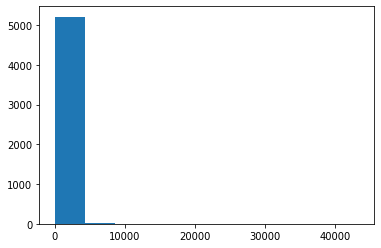

In [9]:
plt.hist(challenges['total_submissions']);

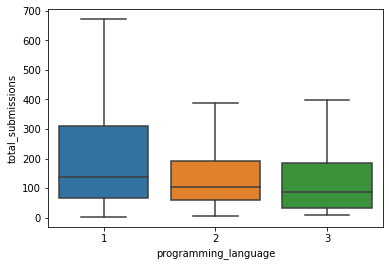

In [10]:
sns.boxplot(x=challenges['programming_language'], y=challenges['total_submissions'], showfliers = False);

As we can see, people usually make more submissions in the first programming language.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


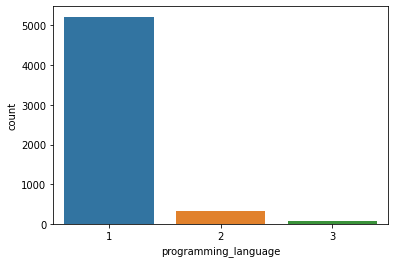

In [11]:
sns.countplot(challenges['programming_language']);

There are huge disproportion in languages of challenges, therefore it would be a good idea focus recommendations on programming languages. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


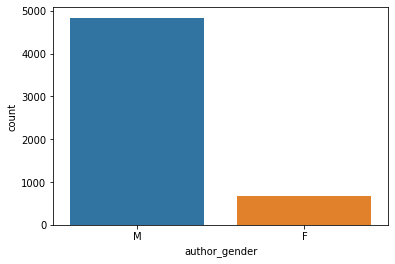

In [12]:
sns.countplot(challenges['author_gender']);

The majority of courses were made by male authors.

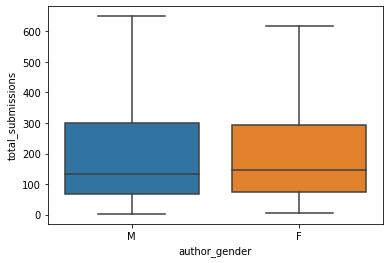

In [13]:
sns.boxplot(x=challenges['author_gender'], y=challenges['total_submissions'], showfliers = False);

The amount of submissions does not depend on gender.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


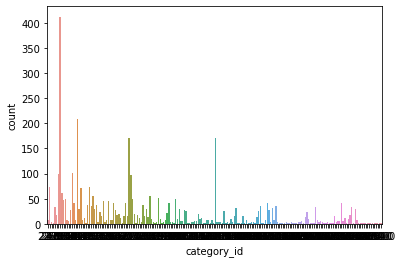

In [14]:
sns.countplot(challenges['category_id']);

There are some categories that are more abundant than others.

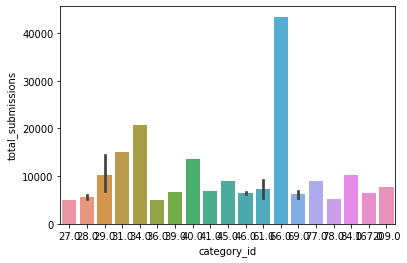

In [15]:
sns.barplot(x='category_id', y='total_submissions', data=challenges[challenges['total_submissions']>5000]);

From the graph we can conclude that some categories are more popular in terms of submissions that others.

## Preprocessing and building models

In [16]:
target = train[train.challenge_sequence > 10][['user_id','challenge']]
target.rename(columns={'challenge':'target'},inplace=True)
target.head()

,user_id,target
10,4576,CI24958
11,4576,CI23667
12,4576,CI23691
23,4580,CI24915
24,4580,CI25727


In [17]:
data = train[train.challenge_sequence <= 10].groupby('user_id').challenge.aggregate(lambda x: ' '.join(x)).reset_index()
data.head()

,user_id,challenge
0,4576,CI23714 CI23855 CI24917 CI23663 CI23933 CI2513...
1,4580,CI23663 CI23855 CI23933 CI23975 CI24530 CI2371...
2,4581,CI26155 CI26156 CI26157 CI26158 CI26159 CI2616...
3,4582,CI23855 CI24915 CI24917 CI23933 CI23663 CI2495...
4,4585,CI23855 CI23975 CI24917 CI25135 CI23848 CI2371...


In [18]:
data = data.merge(target)
data.head()

,user_id,challenge,target
0,4576,CI23714 CI23855 CI24917 CI23663 CI23933 CI2513...,CI24958
1,4576,CI23714 CI23855 CI24917 CI23663 CI23933 CI2513...,CI23667
2,4576,CI23714 CI23855 CI24917 CI23663 CI23933 CI2513...,CI23691
3,4580,CI23663 CI23855 CI23933 CI23975 CI24530 CI2371...,CI24915
4,4580,CI23663 CI23855 CI23933 CI23975 CI24530 CI2371...,CI25727


#### Encode challenges

In [19]:
le = LabelEncoder()
le.fit(challenges['challenge_ID'])
data['challange_encoded'] = le.transform(data.target)

#### Tokenizing

In [20]:
tok = Tokenizer()
tok.fit_on_texts(data['challenge'])
n_words = len(tok.word_index)
max_len = 10
n_cat = challenges.shape[0]

#### Creating sequences

In [21]:
sequences_train = tok.texts_to_sequences(data['challenge'])
x_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
y_train = data['challange_encoded'].values

#### Creating and training model

In [22]:
inputs = Input(shape=(max_len, ))
x = Embedding(n_words+1,256)(inputs)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(256, dropout=0.15, recurrent_dropout=0.15))(x)
x = Dropout(0.4)(x)
outputs = Dense(n_cat, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train, epochs=25, batch_size=2048)

Epoch 1/25
102/102 [==============================] - 24s 158ms/step - loss: 6.2262 - accuracy: 0.0321
Epoch 2/25
102/102 [==============================] - 16s 159ms/step - loss: 4.9443 - accuracy: 0.0591
Epoch 3/25
102/102 [==============================] - 18s 179ms/step - loss: 4.5676 - accuracy: 0.0800
Epoch 4/25
102/102 [==============================] - 16s 158ms/step - loss: 4.3052 - accuracy: 0.0961
Epoch 5/25
102/102 [==============================] - 16s 160ms/step - loss: 4.0981 - accuracy: 0.1109
Epoch 6/25
102/102 [==============================] - 16s 156ms/step - loss: 3.9276 - accuracy: 0.1251
Epoch 7/25
102/102 [==============================] - 16s 156ms/step - loss: 3.7925 - accuracy: 0.1355
Epoch 8/25
102/102 [==============================] - 16s 156ms/step - loss: 3.6776 - accuracy: 0.1441
Epoch 9/25
102/102 [==============================] - 16s 157ms/step - loss: 3.5830 - accuracy: 0.1512
Epoch 10/25
102/102 [==============================] - 16s 157ms/step - l

#### Making predictions

In [24]:
test_text = test[test.challenge_sequence <= 10].groupby('user_id').challenge.aggregate(lambda x: ' '.join(x)).reset_index()
x_test = pad_sequences(tok.texts_to_sequences(test_text.challenge), maxlen=max_len, padding='post', truncating='post')
pred = model.predict(x_test,batch_size=2048)
pred = pred.argsort(axis=1)[:,-3:][:,::-1]

In [25]:
pred1 = []
for i in range(3):
    test1 = test_text[['user_id']]
    test1['user_sequence'] = test1.user_id.astype(str) + '_'+str(i+11)
    test1['challenge'] = le.inverse_transform(pred[:,i])
    pred1.append(test1[['user_sequence','challenge']])
    
pd.concat(pred1).to_csv('/content/submission_LSTM_final.csv',index=False)